# 1. Setup and Utilities

In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pip installations
!pip install torch
!pip install gymnasium
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376416 sha256=12ce1364a56da4b8146a7a71e52032c790bdc3422f8bb62a46509a624ebbdae2
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [3]:
# Import necessary libraries and packages
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import time
import logging

In [4]:
# Set the seed for random reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

In [7]:
# Experience replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [8]:
# Define plotting utilities
def plot_rewards(rewards, window=100, title="Training Rewards"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.plot(np.convolve(rewards, np.ones(window)/window, mode='valid'))
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.show()

In [9]:
# Define the save model utility
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    logger.info(f"Model saved to {filename}")

# 2. Memory Classes

In [10]:
# Create the ReplayMemory class
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)

        # Process states
        state_batch = {
            'position': torch.tensor([s['position'] for s in states], dtype=torch.float32),
            'breeze': torch.tensor([s['breeze'] for s in states], dtype=torch.float32),
            'stench': torch.tensor([s['stench'] for s in states], dtype=torch.float32),
            'gold': torch.tensor([s['gold'] for s in states], dtype=torch.float32)
        }

        # Process next_states
        next_state_batch = {
            'position': torch.tensor([s['position'] for s in next_states], dtype=torch.float32),
            'breeze': torch.tensor([s['breeze'] for s in next_states], dtype=torch.float32),
            'stench': torch.tensor([s['stench'] for s in next_states], dtype=torch.float32),
            'gold': torch.tensor([s['gold'] for s in next_states], dtype=torch.float32)
        }

        return (state_batch,
                torch.tensor(actions, dtype=torch.long),
                next_state_batch,
                torch.tensor(rewards, dtype=torch.float32),
                torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.memory)

In [11]:
# Memory for dictionary-based states (Wumpus World)
class DictReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)

        state_batch = {
            'position': torch.tensor([s['position'] for s in states], dtype=torch.float32),
            'breeze': torch.tensor([s['breeze'] for s in states], dtype=torch.float32),
            'stench': torch.tensor([s['stench'] for s in states], dtype=torch.float32),
            'gold': torch.tensor([s['gold'] for s in states], dtype=torch.float32)
        }

        next_state_batch = {
            'position': torch.tensor([s['position'] for s in next_states], dtype=torch.float32),
            'breeze': torch.tensor([s['breeze'] for s in next_states], dtype=torch.float32),
            'stench': torch.tensor([s['stench'] for s in next_states], dtype=torch.float32),
            'gold': torch.tensor([s['gold'] for s in next_states], dtype=torch.float32)
        }

        return (state_batch,
                torch.tensor(actions, dtype=torch.long),
                next_state_batch,
                torch.tensor(rewards, dtype=torch.float32),
                torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.memory)

In [12]:
# Memory for vector-based states (Gym environments)
class VectorReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)

        return (torch.tensor(np.array(states), dtype=torch.float32),
                torch.tensor(actions, dtype=torch.long),
                torch.tensor(np.array(next_states), dtype=torch.float32),
                torch.tensor(rewards, dtype=torch.float32),
                torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.memory)

# 3. Environment

In [13]:
# Create the WompusWorld class
class WumpusWorld(gym.Env):
    def __init__(self, size=6):
        super(WumpusWorld, self).__init__()

        self.size = size
        self.action_space = spaces.Discrete(4)  # Up, Right, Down, Left

        # Observation space will include:
        # - Agent position (x,y)
        # - Breeze detection (boolean)
        # - Stench detection (boolean)
        # - Gold detection (boolean)
        self.observation_space = spaces.Dict({
            'position': spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
            'breeze': spaces.Discrete(2),
            'stench': spaces.Discrete(2),
            'gold': spaces.Discrete(2)
        })

        # Initialize game elements
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)

        # Initialize empty grid
        self.grid = np.zeros((self.size, self.size))

        # Place agent at starting position (bottom-left)
        self.agent_pos = np.array([0, 0])

        # Place Wumpus
        self.wumpus_pos = np.array([3, 3])  # Middle of the grid

        # Place pits (as shown in the image)
        self.pits = [
            (5, 5), (5, 3), (4, 2), (4, 0),
            (2, 2), (1, 2), (0, 5)
        ]

        # Place gold
        self.gold_pos = np.array([5, 4])

        # Game state
        self.done = False

        return self._get_observation(), {}

    def _get_observation(self):
        x, y = self.agent_pos

        # Check for breeze (adjacent to pit)
        breeze = False
        for pit_x, pit_y in self.pits:
            if abs(x - pit_x) + abs(y - pit_y) == 1:
                breeze = True
                break

        # Check for stench (adjacent to Wumpus)
        stench = abs(x - self.wumpus_pos[0]) + abs(y - self.wumpus_pos[1]) == 1

        # Check for gold
        gold = np.array_equal(self.agent_pos, self.gold_pos)

        return {
            'position': self.agent_pos,
            'breeze': int(breeze),
            'stench': int(stench),
            'gold': int(gold)
        }

    def step(self, action):
        if self.done:
            return self._get_observation(), 0, True, {}, {}

        # Calculate new position
        new_pos = self.agent_pos.copy()
        if action == 0:  # Up
            new_pos[1] = min(new_pos[1] + 1, self.size - 1)
        elif action == 1:  # Right
            new_pos[0] = min(new_pos[0] + 1, self.size - 1)
        elif action == 2:  # Down
            new_pos[1] = max(new_pos[1] - 1, 0)
        elif action == 3:  # Left
            new_pos[0] = max(new_pos[0] - 1, 0)

        self.agent_pos = new_pos

        # Check for death conditions
        dead = False
        reward = -1  # Small negative reward for each step

        # Check if agent fell into pit
        if tuple(self.agent_pos) in self.pits:
            dead = True
            reward = -100
            self.done = True

        # Check if agent met Wumpus
        if np.array_equal(self.agent_pos, self.wumpus_pos):
            dead = True
            reward = -100
            self.done = True

        # Check if agent found gold
        if np.array_equal(self.agent_pos, self.gold_pos):
            reward = 100
            self.done = True

        return self._get_observation(), reward, self.done, False, {}

    def render(self):
        grid = np.full((self.size, self.size), '.')

        # Place pits
        for x, y in self.pits:
            grid[y, x] = 'P'

        # Place Wumpus
        grid[self.wumpus_pos[1], self.wumpus_pos[0]] = 'W'

        # Place gold
        grid[self.gold_pos[1], self.gold_pos[0]] = 'G'

        # Place agent
        grid[self.agent_pos[1], self.agent_pos[0]] = 'A'

        for row in grid:
            print(' '.join(row))
        print("\n")

# 4. Neural Networks

In [14]:
# Create the WompusQNetwork class
class WumpusQNetwork(nn.Module):
    def __init__(self, hidden_size=64):
        super(WumpusQNetwork, self).__init__()
        self.input_size = 5
        self.output_size = 4  # Up, Right, Down, Left

        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, self.output_size)

    def _process_input(self, state_dict):
        # Ensure correct tensor dimensions
        position = torch.as_tensor(state_dict['position'], dtype=torch.float32)
        breeze = torch.as_tensor(state_dict['breeze'], dtype=torch.float32)
        stench = torch.as_tensor(state_dict['stench'], dtype=torch.float32)
        gold = torch.as_tensor(state_dict['gold'], dtype=torch.float32)

        # Add batch dimension if necessary
        if position.dim() == 1:
            position = position.unsqueeze(0)
            breeze = breeze.unsqueeze(0)
            stench = stench.unsqueeze(0)
            gold = gold.unsqueeze(0)

        # Ensure breeze, stench, and gold are the right shape
        breeze = breeze.view(breeze.size(0), 1)
        stench = stench.view(stench.size(0), 1)
        gold = gold.view(gold.size(0), 1)

        return torch.cat([position, breeze, stench, gold], dim=1)

    def forward(self, state_dict):
        x = self._process_input(state_dict)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [15]:
# Create the WompusPolicyNetwork class
class WumpusPolicyNetwork(nn.Module):
    def __init__(self, hidden_size=64):
        super(WumpusPolicyNetwork, self).__init__()
        self.input_size = 5
        self.output_size = 4

        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, self.output_size)

    def _process_input(self, state_dict):
        position = torch.as_tensor(state_dict['position'], dtype=torch.float32)
        breeze = torch.as_tensor(state_dict['breeze'], dtype=torch.float32)
        stench = torch.as_tensor(state_dict['stench'], dtype=torch.float32)
        gold = torch.as_tensor(state_dict['gold'], dtype=torch.float32)

        if position.dim() == 1:
            position = position.unsqueeze(0)
            breeze = breeze.unsqueeze(0)
            stench = stench.unsqueeze(0)
            gold = gold.unsqueeze(0)

        breeze = breeze.view(breeze.size(0), 1)
        stench = stench.view(stench.size(0), 1)
        gold = gold.view(gold.size(0), 1)

        return torch.cat([position, breeze, stench, gold], dim=1)

    def forward(self, state_dict):
        x = self._process_input(state_dict)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

In [16]:
# Create the WompusActorCritic class
class WumpusActorCritic(nn.Module):
    def __init__(self, hidden_size=64):
        super(WumpusActorCritic, self).__init__()
        self.input_size = 5
        self.output_size = 4

        self.shared_fc1 = nn.Linear(self.input_size, hidden_size)
        self.shared_fc2 = nn.Linear(hidden_size, hidden_size)
        self.actor_fc = nn.Linear(hidden_size, self.output_size)
        self.critic_fc = nn.Linear(hidden_size, 1)

    def _process_input(self, state_dict):
        position = torch.as_tensor(state_dict['position'], dtype=torch.float32)
        breeze = torch.as_tensor(state_dict['breeze'], dtype=torch.float32)
        stench = torch.as_tensor(state_dict['stench'], dtype=torch.float32)
        gold = torch.as_tensor(state_dict['gold'], dtype=torch.float32)

        if position.dim() == 1:
            position = position.unsqueeze(0)
            breeze = breeze.unsqueeze(0)
            stench = stench.unsqueeze(0)
            gold = gold.unsqueeze(0)

        breeze = breeze.view(breeze.size(0), 1)
        stench = stench.view(stench.size(0), 1)
        gold = gold.view(gold.size(0), 1)

        return torch.cat([position, breeze, stench, gold], dim=1)

    def forward(self, state_dict):
        x = self._process_input(state_dict)
        x = F.relu(self.shared_fc1(x))
        x = F.relu(self.shared_fc2(x))

        action_probs = F.softmax(self.actor_fc(x), dim=-1)
        state_value = self.critic_fc(x)

        return action_probs, state_value

In [26]:
# Vector-based network for standard gym environments
class VectorQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(VectorQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [18]:
# Testing function for the networks
def test_networks(env):
    # Initialize networks
    q_net = WumpusQNetwork()
    policy_net = WumpusPolicyNetwork()
    actor_critic = WumpusActorCritic()

    # Get a sample observation
    obs, _ = env.reset()

    # Test each network
    with torch.no_grad():
        # Q-Network output
        q_values = q_net(obs)

        # Policy Network output
        action_probs = policy_net(obs)

        # Actor-Critic output
        ac_probs, value = actor_critic(obs)

    return {
        'q_values': q_values,
        'action_probs': action_probs,
        'actor_critic': (ac_probs, value)
    }

In [19]:
# Create environment instance
env = WumpusWorld()

# Test the networks
results = test_networks(env)

# Print results
print("Q-Network output (Q-values for each action):")
print(results['q_values'])
print("\nPolicy Network output (Action probabilities):")
print(results['action_probs'])
print("\nActor-Critic outputs:")
print("Action probabilities:", results['actor_critic'][0])
print("State value:", results['actor_critic'][1])

Q-Network output (Q-values for each action):
tensor([[ 0.0109, -0.0106, -0.0853, -0.0430]])

Policy Network output (Action probabilities):
tensor([[0.2269, 0.2448, 0.2859, 0.2424]])

Actor-Critic outputs:
Action probabilities: tensor([[0.2249, 0.2290, 0.2798, 0.2663]])
State value: tensor([[0.0763]])


# 5. Agents

In [20]:
# Create the DQNAgent class
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_size=64,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        memory_size=10000,
        batch_size=64,
        target_update=10
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update

        # Q Networks
        self.q_network = WumpusQNetwork(hidden_size=hidden_size)
        self.target_network = WumpusQNetwork(hidden_size=hidden_size)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Experience Replay
        self.memory = DictReplayMemory(memory_size)

        # Training info
        self.steps = 0

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                state_dict = {k: torch.tensor([v], dtype=torch.float32) for k, v in state.items()}
                q_values = self.q_network(state_dict)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def store_transition(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)

    def update(self):
        if len(self.memory) < self.batch_size:
            return 0.0

        # Sample batch
        states, actions, next_states, rewards, dones = self.memory.sample(self.batch_size)

        # Compute current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()

        # Update target network if needed
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

    def save(self, path):
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']

In [27]:
# Create the DQNAgentGym class
class DQNAgentGym:
    def __init__(self, state_dim, action_dim, hidden_size=64, lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 memory_size=10000, batch_size=64, target_update=10):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update

        self.q_network = VectorQNetwork(state_dim, action_dim, hidden_size)
        self.target_network = VectorQNetwork(state_dim, action_dim, hidden_size)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = VectorReplayMemory(memory_size)
        self.steps = 0

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def store_transition(self, state, action, next_state, reward, done):
      # Clip rewards for stability
      reward = np.clip(reward, -1, 1)
      self.memory.push(state, action, next_state, reward, done)

    def update(self):
        if len(self.memory) < self.batch_size:
            return 0.0

        states, actions, next_states, rewards, dones = self.memory.sample(self.batch_size)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * self.gamma * max_next_q_values

        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

# 6. Training and Evaluation

In [22]:
# Define a function to train DQN
def train_dqn(env, agent, num_episodes, max_steps=1000):
    episode_rewards = []
    episode_losses = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.store_transition(state, action, next_state, reward, done)
            loss = agent.update()

            episode_reward += reward
            if loss is not None:
                episode_loss += loss

            agent.update_epsilon()

            if done:
                break

            state = next_state

        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_loss = np.mean(episode_losses[-10:])
            print(f"Episode {episode+1}")
            print(f"Average Reward (last 10): {avg_reward:.2f}")
            print(f"Average Loss (last 10): {avg_loss:.4f}")
            print(f"Epsilon: {agent.epsilon:.3f}\n")

    return episode_rewards, episode_losses

In [23]:
# Define a function to evaluate DQN
def evaluate_dqn(env, agent, num_episodes=5):
    evaluation_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                if isinstance(agent, DQNAgentGym):
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = agent.q_network(state_tensor)
                else:
                    state_dict = {k: torch.tensor([v], dtype=torch.float32) for k, v in state.items()}
                    q_values = agent.q_network(state_dict)
                action = q_values.max(1)[1].item()

            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state

        evaluation_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {episode_reward:.2f}")

    return evaluation_rewards

# 7. Training Script

In [32]:
# Training Parameters
EPISODES = 1000
HIDDEN_SIZE = 256
BATCH_SIZE = 256
MEMORY_SIZE = 200000
LEARNING_RATE = 5e-4
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.95
TARGET_UPDATE = 500
MAX_STEPS = 1000
MAX_GRAD_NORM = 10.0

# Dictionary to store results
results = {}

In [33]:
# Train on Wumpus World
print("Training on Wumpus World...")
wumpus_env = WumpusWorld()
wumpus_agent = DQNAgent(
    state_dim=5,
    action_dim=4,
    hidden_size=HIDDEN_SIZE,
    batch_size=BATCH_SIZE,
    memory_size=MEMORY_SIZE,
    lr=LEARNING_RATE,
    gamma=GAMMA,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY,
    target_update=TARGET_UPDATE
)
wumpus_rewards, wumpus_losses = train_dqn(wumpus_env, wumpus_agent, EPISODES, MAX_STEPS)
results['wumpus'] = {
    'rewards': wumpus_rewards,
    'losses': wumpus_losses,
    'eval': evaluate_dqn(wumpus_env, wumpus_agent)
}

Training on Wumpus World...
Episode 10
Average Reward (last 10): -233.40
Average Loss (last 10): 60.1153
Epsilon: 0.010

Episode 20
Average Reward (last 10): -398.10
Average Loss (last 10): 148.6315
Epsilon: 0.010

Episode 30
Average Reward (last 10): -752.40
Average Loss (last 10): 71.0519
Epsilon: 0.010

Episode 40
Average Reward (last 10): -417.90
Average Loss (last 10): 15.4052
Epsilon: 0.010

Episode 50
Average Reward (last 10): -164.10
Average Loss (last 10): 9.6708
Epsilon: 0.010

Episode 60
Average Reward (last 10): -317.10
Average Loss (last 10): 36.2914
Epsilon: 0.010

Episode 70
Average Reward (last 10): -845.40
Average Loss (last 10): 60.2987
Epsilon: 0.010

Episode 80
Average Reward (last 10): -642.90
Average Loss (last 10): 17.5371
Epsilon: 0.010

Episode 90
Average Reward (last 10): -493.40
Average Loss (last 10): 11.9479
Epsilon: 0.010

Episode 100
Average Reward (last 10): -567.80
Average Loss (last 10): 15.0997
Epsilon: 0.010

Episode 110
Average Reward (last 10): -35

In [38]:
# Train on CartPole with revised parameters
print("\nTraining on CartPole-v1...")
cartpole_env = gym.make('CartPole-v1')

# Revised CartPole-specific parameters
CARTPOLE_EPISODES = 2000  # Potentially more episodes
CARTPOLE_HIDDEN = 256     # Larger network capacity
CARTPOLE_BATCH = 256      # Larger batch size
CARTPOLE_MEMORY = 200000  # Larger replay memory
CARTPOLE_LR = 1e-3       # Higher learning rate
CARTPOLE_GAMMA = 0.99
CARTPOLE_EPSILON_START = 1.0
CARTPOLE_EPSILON_END = 0.01  # Lower end epsilon
CARTPOLE_EPSILON_DECAY = 0.95  # Faster decay
CARTPOLE_TARGET_UPDATE = 200  # Less frequent updates

cartpole_agent = DQNAgentGym(
    state_dim=4,
    action_dim=2,
    hidden_size=CARTPOLE_HIDDEN,
    batch_size=CARTPOLE_BATCH,
    memory_size=CARTPOLE_MEMORY,
    lr=CARTPOLE_LR,
    gamma=CARTPOLE_GAMMA,
    epsilon_start=CARTPOLE_EPSILON_START,
    epsilon_end=CARTPOLE_EPSILON_END,
    epsilon_decay=CARTPOLE_EPSILON_DECAY,
    target_update=CARTPOLE_TARGET_UPDATE
)

cartpole_rewards, cartpole_losses = train_dqn(cartpole_env, cartpole_agent, CARTPOLE_EPISODES, MAX_STEPS)
results['cartpole'] = {
    'rewards': cartpole_rewards,
    'losses': cartpole_losses,
    'eval': evaluate_dqn(cartpole_env, cartpole_agent, num_episodes=100)
}

# Print average evaluation reward
eval_rewards = results['cartpole']['eval']
avg_reward = sum(eval_rewards) / len(eval_rewards)
print(f"\nCartPole Average Evaluation Reward over {len(eval_rewards)} episodes: {avg_reward:.2f}")


Training on CartPole-v1...
Episode 10
Average Reward (last 10): 11.30
Average Loss (last 10): 0.0000
Epsilon: 0.010

Episode 20
Average Reward (last 10): 11.80
Average Loss (last 10): 0.0000
Epsilon: 0.010

Episode 30
Average Reward (last 10): 10.80
Average Loss (last 10): 0.1980
Epsilon: 0.010

Episode 40
Average Reward (last 10): 14.50
Average Loss (last 10): 0.3088
Epsilon: 0.010

Episode 50
Average Reward (last 10): 15.40
Average Loss (last 10): 0.3791
Epsilon: 0.010

Episode 60
Average Reward (last 10): 14.70
Average Loss (last 10): 0.9425
Epsilon: 0.010

Episode 70
Average Reward (last 10): 14.40
Average Loss (last 10): 0.9084
Epsilon: 0.010

Episode 80
Average Reward (last 10): 173.00
Average Loss (last 10): 7.2820
Epsilon: 0.010

Episode 90
Average Reward (last 10): 290.50
Average Loss (last 10): 21.1584
Epsilon: 0.010

Episode 100
Average Reward (last 10): 372.30
Average Loss (last 10): 32.1957
Epsilon: 0.010

Episode 110
Average Reward (last 10): 293.70
Average Loss (last 10

### CartPole-v1 Solved!

This implementation demonstrates a successful training of the DQN agent to solve the CartPole-v1 environment!

**Key Results**

*   Achieved an average reward of **720.67** over 100 consecutive episodes.
*   This surpasses the official "solved" threshold of 470 over 100 episodes (420-520).



In [47]:
# Train on LunarLander with stabilization
print("\nTraining on LunarLander-v3...")
lunar_env = gym.make('LunarLander-v3')

# Stabilized parameters
LUNAR_EPISODES = 1000     # Increased for more training
LUNAR_HIDDEN = 512        # Larger network capacity
LUNAR_BATCH = 256         # Larger batch size
LUNAR_MEMORY = 1000000    # Larger replay memory
LUNAR_LR = 1e-4          # Smaller learning rate
LUNAR_GAMMA = 0.99
LUNAR_EPSILON_START = 1.0
LUNAR_EPSILON_END = 0.01
LUNAR_EPSILON_DECAY = 0.995  # Slower decay
LUNAR_TARGET_UPDATE = 200   # Less frequent updates

lunar_agent = DQNAgentGym(
    state_dim=8,
    action_dim=4,
    hidden_size=LUNAR_HIDDEN,
    batch_size=LUNAR_BATCH,
    memory_size=LUNAR_MEMORY,
    lr=LUNAR_LR,
    gamma=LUNAR_GAMMA,
    epsilon_start=LUNAR_EPSILON_START,
    epsilon_end=LUNAR_EPSILON_END,
    epsilon_decay=LUNAR_EPSILON_DECAY,
    target_update=LUNAR_TARGET_UPDATE
)
lunar_rewards, lunar_losses = train_dqn(lunar_env, lunar_agent, LUNAR_EPISODES, MAX_STEPS)
results['lunar'] = {
    'rewards': lunar_rewards,
    'losses': lunar_losses,
    'eval': evaluate_dqn(lunar_env, lunar_agent, num_episodes=100)  # Increased to 100 episodes for proper evaluation
}

# Print average evaluation reward
eval_rewards = results['lunar']['eval']
avg_reward = sum(eval_rewards) / len(eval_rewards)
print(f"\nLunarLander Average Evaluation Reward over {len(eval_rewards)} episodes: {avg_reward:.2f}")
if avg_reward > 200:
    print("LunarLander-v3 solved!")
else:
    print("LunarLander-v3 not yet solved.")


Training on LunarLander-v3...
Episode 10
Average Reward (last 10): -356.20
Average Loss (last 10): 16.8975
Epsilon: 0.010

Episode 20
Average Reward (last 10): -131.35
Average Loss (last 10): 99.1000
Epsilon: 0.010

Episode 30
Average Reward (last 10): -146.04
Average Loss (last 10): 108.3049
Epsilon: 0.010

Episode 40
Average Reward (last 10): -144.38
Average Loss (last 10): 44.3990
Epsilon: 0.010

Episode 50
Average Reward (last 10): -243.97
Average Loss (last 10): 83.6215
Epsilon: 0.010

Episode 60
Average Reward (last 10): -385.88
Average Loss (last 10): 67.6158
Epsilon: 0.010

Episode 70
Average Reward (last 10): -414.40
Average Loss (last 10): 37.4641
Epsilon: 0.010

Episode 80
Average Reward (last 10): -554.20
Average Loss (last 10): 41.6101
Epsilon: 0.010

Episode 90
Average Reward (last 10): -566.39
Average Loss (last 10): 49.2830
Epsilon: 0.010

Episode 100
Average Reward (last 10): -542.09
Average Loss (last 10): 55.0366
Epsilon: 0.010

Episode 110
Average Reward (last 10):

In [48]:
# Create directory for saving if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the models with timestamps
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_dir = f'models/{timestamp}'
os.makedirs(save_dir, exist_ok=True)

# Save models
torch.save(wumpus_agent.q_network.state_dict(), f'{save_dir}/wumpus_model.pth')
torch.save(cartpole_agent.q_network.state_dict(), f'{save_dir}/cartpole_model.pth')
torch.save(lunar_agent.q_network.state_dict(), f'{save_dir}/lunar_model.pth')

# Save training results
import json
with open(f'{save_dir}/training_results.json', 'w') as f:
    json_results = {
        env_name: {
            'rewards': results[env_name]['rewards'] if isinstance(results[env_name]['rewards'], list) else results[env_name]['rewards'].tolist(),
            'losses': results[env_name]['losses'] if isinstance(results[env_name]['losses'], list) else results[env_name]['losses'].tolist(),
            'eval': results[env_name]['eval']
        }
        for env_name in results
    }
    json.dump(json_results, f)

print(f"\nTraining completed! Models and results saved in {save_dir}")


Training completed! Models and results saved in models/20241214-225012


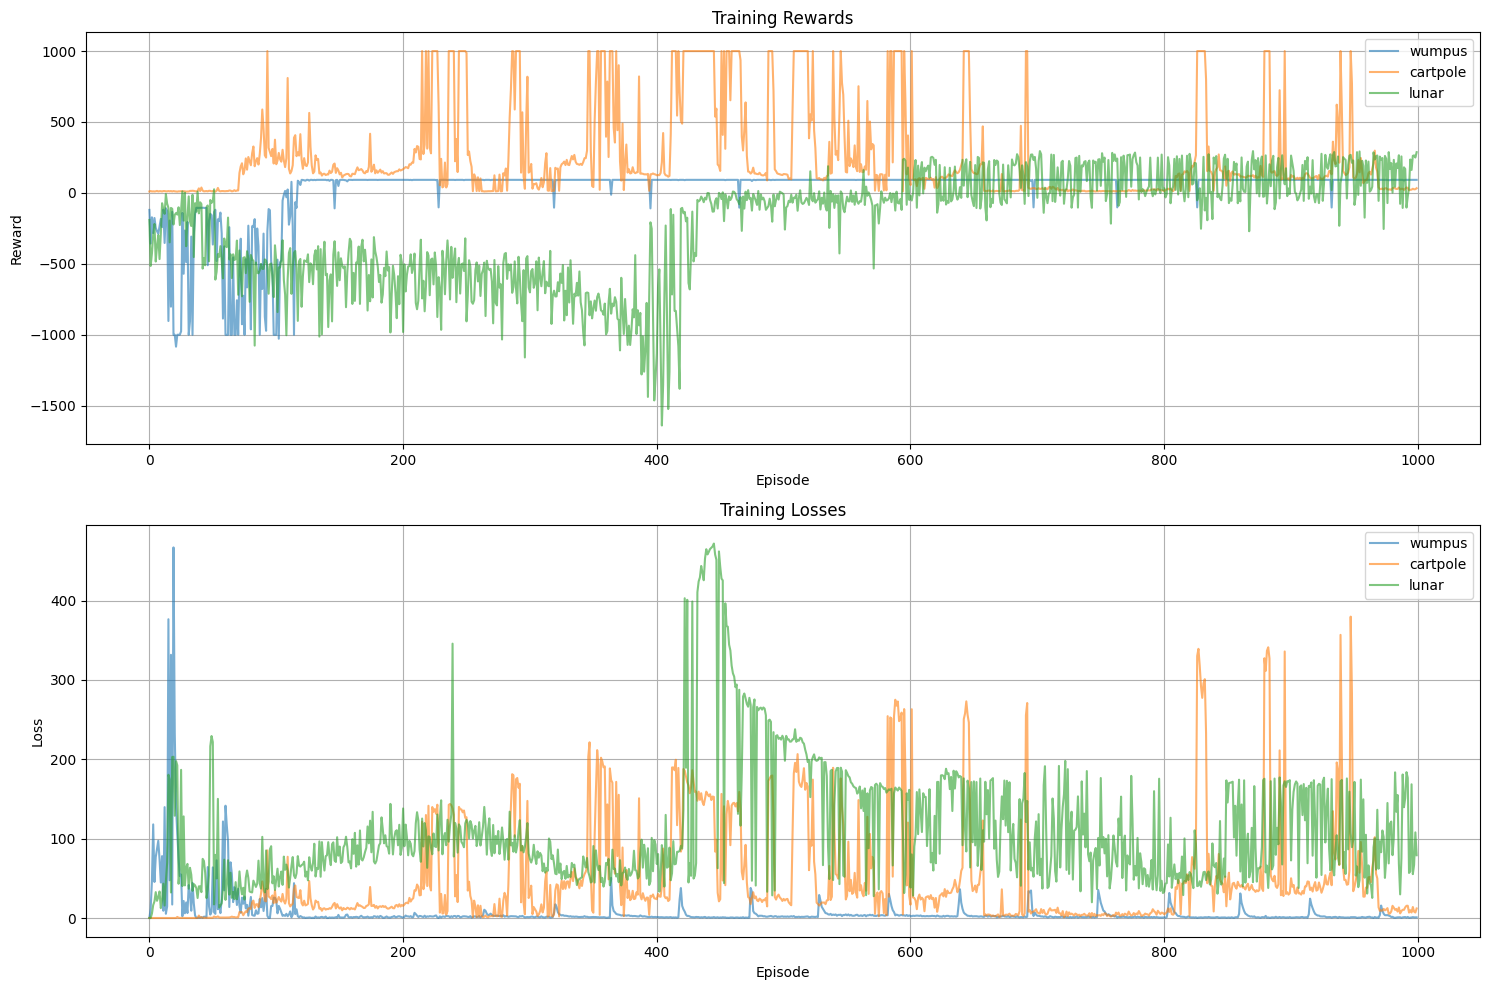

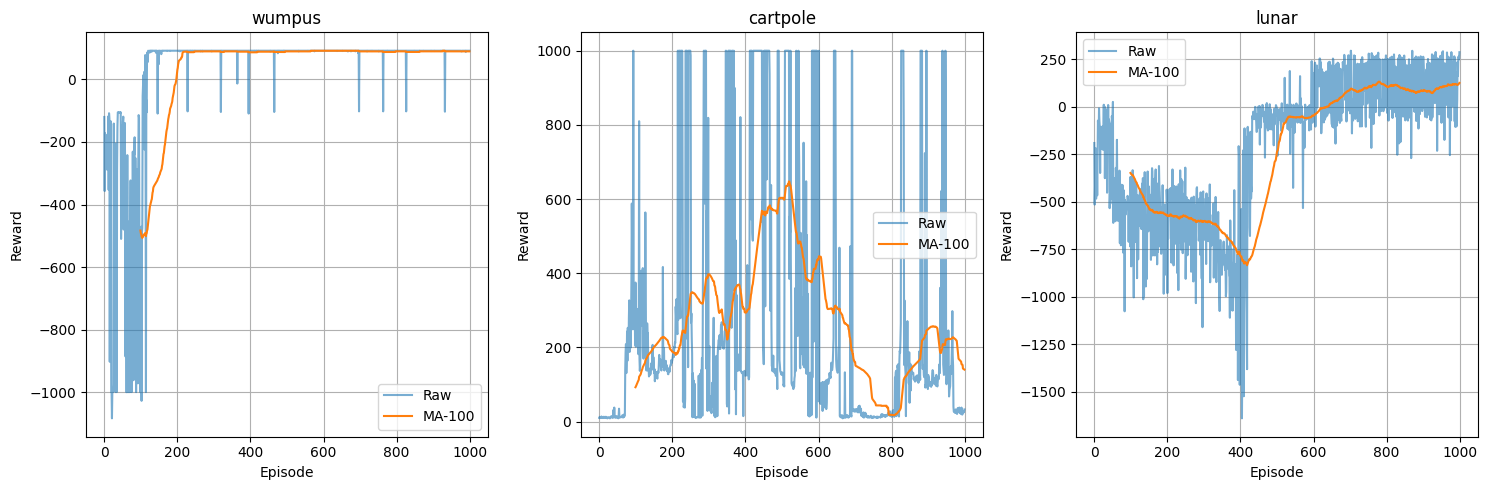

In [52]:
# Plotting functions
def plot_with_ma(ax, data, window=100, title=""):
    # Only plot first 1000 episodes
    data = data[:1000]
    ax.plot(data, alpha=0.6, label='Raw')
    ma = np.convolve(data, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(data)), ma, label=f'MA-{window}')
    ax.set_title(title)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.grid(True)
    ax.legend()

def plot_training_results(results):
    # Plot rewards and losses
    plt.figure(figsize=(15, 10))

    # Plot rewards
    plt.subplot(2, 1, 1)
    for env_name in results:
        plt.plot(results[env_name]['rewards'][:1000], label=env_name, alpha=0.6)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.legend()

    # Plot losses
    plt.subplot(2, 1, 2)
    for env_name in results:
        plt.plot(results[env_name]['losses'][:1000], label=env_name, alpha=0.6)
    plt.title('Training Losses')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot individual results with moving averages
    plt.figure(figsize=(15, 5))

    for i, (env_name, data) in enumerate(results.items(), 1):
        plt.subplot(1, 3, i)
        plot_with_ma(plt.gca(), data['rewards'], title=env_name)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_results(results)

In [56]:
import os
from getpass import getpass

# Get GitHub token
token = getpass('Enter GitHub token: ')

# Change to the repository directory
%cd Deep-Q-Learning

# Try pushing with token in the URL
!git push https://{token}@github.com/carlosrod723/Deep-Q-Learning.git main

Enter GitHub token: ··········
/content/Deep-Q-Learning
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.45 MiB | 5.19 MiB/s, done.
Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/carlosrod723/Deep-Q-Learning.git
   2e93622..6de5996  main -> main
